In [ ]:
!cd .. && mkdir build
!cd ../build/ && rm -rf *
!cd ../build && cmake \
  -DPYTHON_EXECUTABLE="$(which python)" \
  -DCMAKE_BUILD_TYPE=Release ..
!cd ../build && make install


/home/jazzer/Facultad/metodos_numericos_3/mt/tp3/notebooks
Python 3.6.10
['Sonora' 'Baja California' 'Chihuahua' 'Coahuila' 'Tamaulipas'
 'Nuevo León' 'Quintana Roo' 'Campeche' 'Tabasco' 'Chiapas' 'Colima'
 'Nayarit' 'Baja California Sur' 'Sinaloa' 'Yucatán' 'Veracruz' 'Jalisco'
 'Michoacán' 'Guerrero' 'Oaxaca' None 'México' 'Puebla' 'Morelos'
 'Querétaro' 'Hidalgo' 'Guanajuato' 'San Luis Potosí' 'Zacatecas'
 'Aguascalientes' 'Durango' 'Tlaxcala' 'Distrito Federal']

-------Distrito Federal-------


-------Jalisco-------


-------Edo. de México-------


-------Oaxaca-------


-------Quintana Roo-------


-------Colima-------


-------San luis Potosí-------


-------Nuevo León-------


-------Querétaro-------


-------Tamaulipas-------


-------Puebla-------


-------Yucatán-------


-------Morelos-------


-------Guerrero-------


-------Tabasco-------


-------Guanajuato-------


-------Hidalgo-------


-------Veracruz-------


-------Chihuahua-------


-------Aguascalientes-------




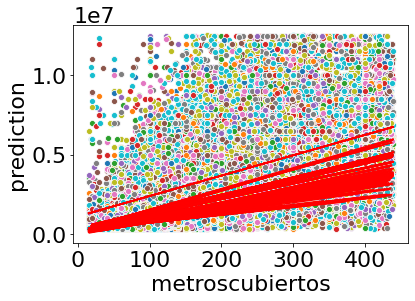

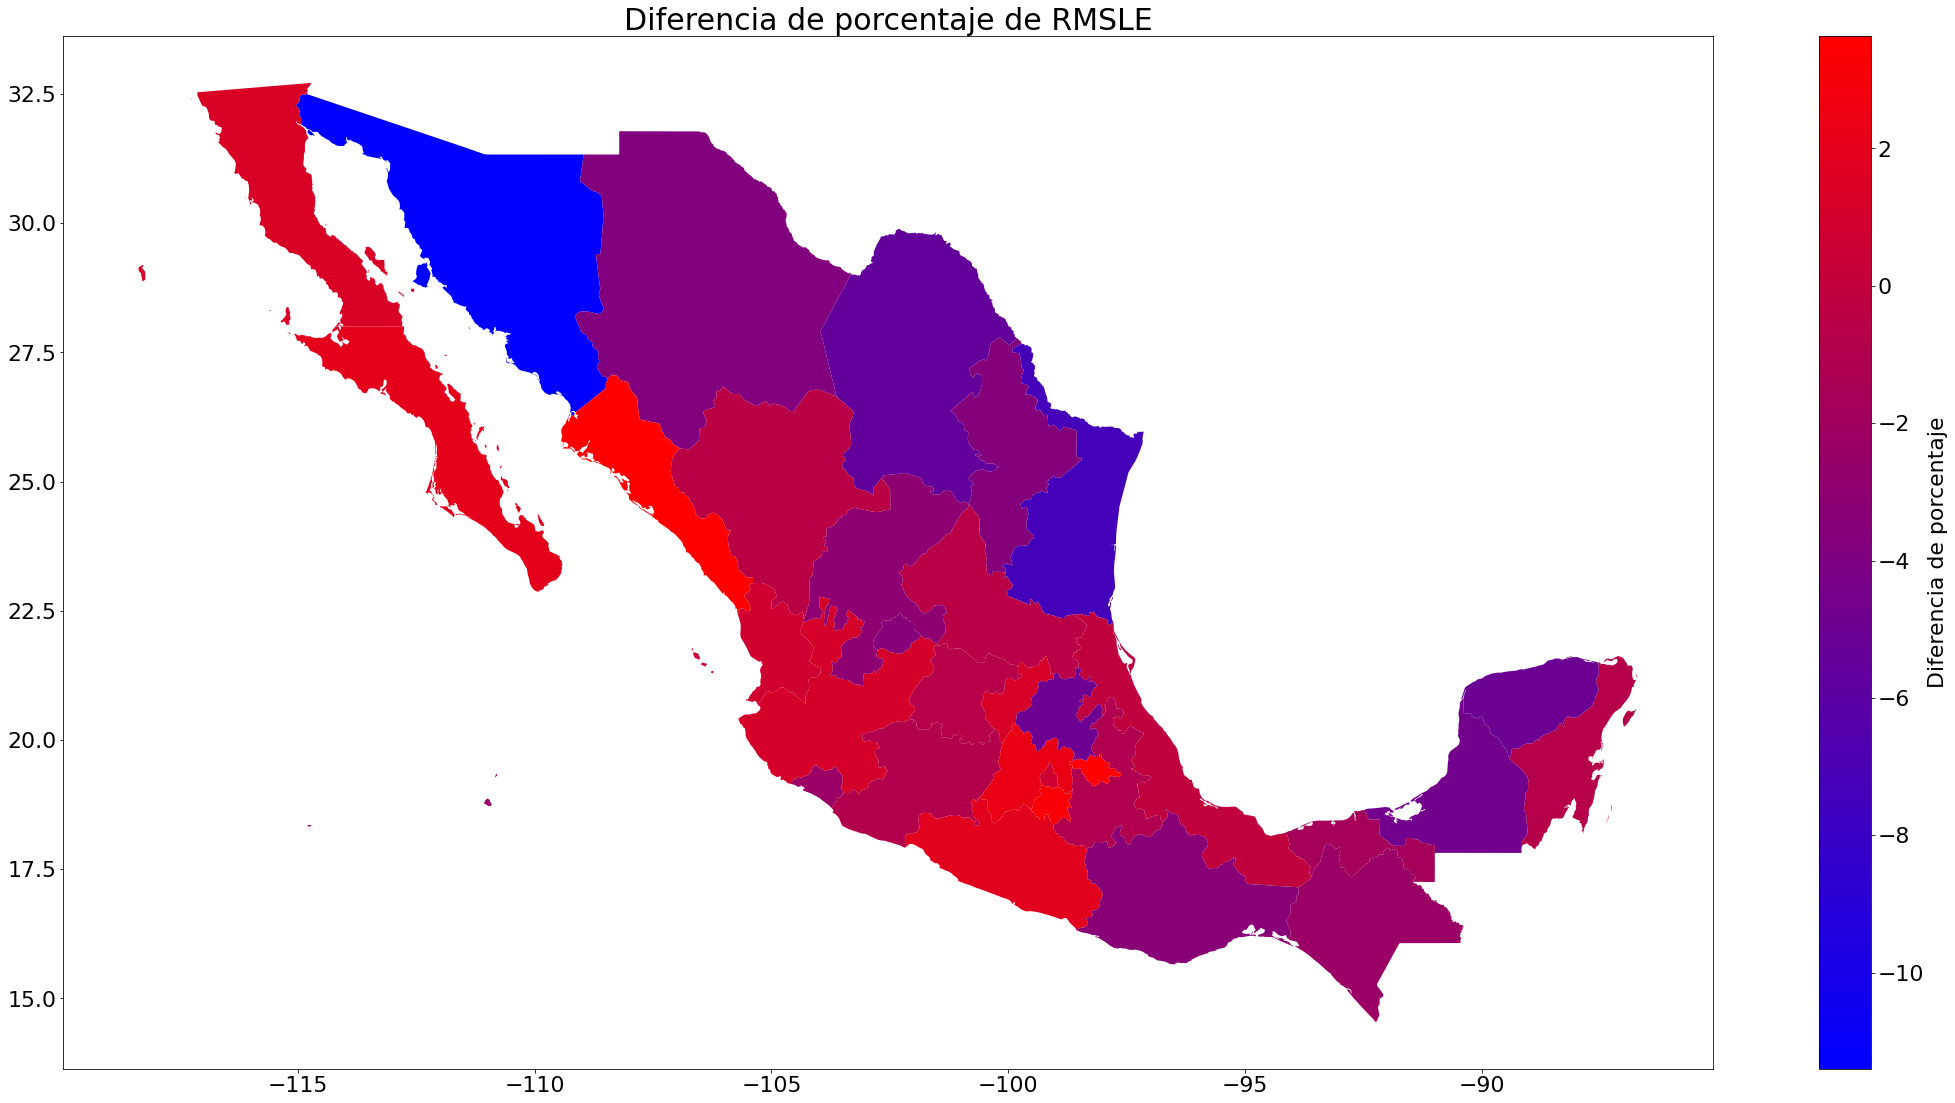

In [31]:
import geopandas as gpd
import pandas as pd
import numpy as np
import time
import math
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.metrics import *
from matplotlib.colors import LinearSegmentedColormap

!pwd
!python --version
import metnum

def mejora(row):
    return ((100*row['rmsle'])/row['rmsle_viejo']) -100
    

def calculate_metrics(variable_to_predict, df_old):
    df = df_old.copy(deep=True)
    df = df[df['prediction'].notna()]
    df = df[df['prediction']>-1]
    return (math.sqrt(mean_squared_error(df[variable_to_predict], df['prediction'])),
            math.sqrt(mean_squared_log_error(df[variable_to_predict]+1, df['prediction']+1)))


def experiment(percentage_of_training_cases,
         variable_to_predict,
         variables_to_study,
         seed, 
         df_old,
         data):
    df = df_old.copy(deep=True)

    t0 = time.time()

    df = df[0:].sample(frac=1, random_state=seed)
    
    #cleanup
    df = df[df[variable_to_predict].notna()]
    for var in variables_to_study:
        df = df[df[var].notna()]
        
    TOTAL_TRAIN_CASES = int(percentage_of_training_cases*len(df))
    
    df_prediction = df[TOTAL_TRAIN_CASES:].copy(deep=True)

    df = df[:TOTAL_TRAIN_CASES]
    df = ( df[df['precio'].between(df['precio'].quantile(.01), df['precio'].quantile(.95))] )
    
    x_train, y_train = df[variables_to_study].values, df[variable_to_predict].values
    x_predict, y_predict = df_prediction[variables_to_study].values, df_prediction[variable_to_predict].values
    
    x_train = x_train.reshape(len(x_train),len(variables_to_study))
    y_train = y_train.reshape(len(y_train),1)
    x_predict = x_predict.reshape(len(x_predict),len(variables_to_study))
    y_predict = y_predict.reshape(len(y_predict),1)

    linear_regressor = metnum.LinearRegression()
    linear_regressor.fit(x_train, y_train)
    df_prediction['prediction'] = linear_regressor.predict(x_predict)

    t1 = time.time()
    total_time = (t1-t0)
    
    rmse, rmsle = calculate_metrics(variable_to_predict, df_prediction)
    data['rmse'].append(rmse)
    data['rmsle'].append(rmsle)
    data['percentage_of_train_cases'].append(percentage_of_training_cases)
    data['time'].append(total_time)
    
    if(len(variables_to_study)==1):
        sns.scatterplot(data=df_prediction, x=variables_to_study[0], y=variable_to_predict)
        sns.lineplot(data=df_prediction, x=variables_to_study[0], y='prediction', color='red')
    elif(len(variables_to_study)==2):
        fig = plt.figure(figsize=(20,10))
        ax = fig.gca(projection='3d')
        ax.set_xlabel('X', fontsize=15, rotation=150)
        ax.set_ylabel('Y')
        ax.set_zlabel(r'Z', fontsize=15)
        ax.scatter(df_prediction[variables_to_study[0]],
                   df_prediction[variables_to_study[1]],
                   df_prediction['prediction'], c='skyblue', s=60)
        ax.plot_trisurf(df_prediction[variables_to_study[0]], 
                        df_prediction[variables_to_study[1]], 
                        df_prediction['prediction'], cmap=plt.cm.viridis, linewidth=0.2)
        plt.show()
    return df_prediction
    
df = pd.read_csv('../data/train.csv')

df_provincias = df.copy(deep=True)
df_provincias = df_provincias[df_provincias['provincia'].notna()]
provinces = df_provincias['provincia'].unique()

shapefile = 'ne_10m_admin_1_states_provinces/ne_10m_admin_1_states_provinces.shp'

#Read shapefile using Geopandas
gdf = gpd.read_file(shapefile)[['name','admin','adm0_a3', 'geometry']]

#Rename columns.
gdf.columns = ['province','country', 'country_code', 'geometry']
gdf = gdf[gdf['country'] == 'Mexico']

print(gdf['province'].unique())

folder='./test_precio_y_con_percentiles_zarpados_{}'.format(int(time.time()))
os.mkdir(folder)

rmsle_averages =[]
for provincia in provinces:
    print('\n-------'+provincia+'-------\n')
    d = {'rmse' : [], 'rmsle' : [], 'percentage_of_train_cases' : [], 'time' : []}
    df_provincia = df_provincias.copy(deep=True)
    df_provincia = df_provincia[df_provincia['provincia'] == provincia ]

    for j in np.arange(1,11,1):
        df_prediction = experiment(0.9, 'precio', ['metroscubiertos'], j, df_provincia, d)
        df_prediction.to_csv(folder+'/prediction_'+provincia+'_'+str(j)+'.csv', 
                                 encoding='utf-8', index=False)

    d_error = pd.DataFrame(data=d)    
    rmsle_averages.append([provincia, d_error['rmsle'].mean()])
    d_error.to_csv(folder+'/error_'+provincia+'.csv', encoding='utf-8', index=False)

rmsle_averages[6][0] = 'San Luis Potosí'
rmsle_averages[22][0] = 'Baja California'
rmsle_averages[2][0] = 'México'
df_rmsle_average = pd.DataFrame(rmsle_averages, columns = ['province','rmsle'])

# Create the pandas DataFrame 
merged = gdf.merge(df_rmsle_average, left_on = 'province', right_on = 'province')

merged_old = gpd.read_file('test_precio_y_provincia_1598410601/geopandas.shp')

merged['rmsle_viejo'] = merged_old['rmsle'].to_numpy()

merged['improvement'] = merged.apply(lambda row: mejora(row),axis=1)

merged.to_file(folder+'/geopandas.shp', encoding='utf-8')
#merged = gpd.read_file(folder+'/geopandas.shp')

print(merged['improvement'])

plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(1, 1)
ax.set_title("Diferencia de porcentaje de RMSLE", fontsize=30)
fig.set_size_inches(38, 19, forward=True)

cmap = LinearSegmentedColormap.from_list(
    'mycmap', [(0, 'blue'), (1, 'red')])

merged.plot(column='improvement', ax=ax, cmap=cmap, legend=True, legend_kwds={'label': "Diferencia de porcentaje"})

/home/jazzer/Facultad/metodos_numericos_3/mt/tp3/notebooks
Python 3.6.10
0     0.439399
1     0.394084
2     0.438658
3     0.403696
4     0.418244
5     0.600348
6     0.512083
7     0.598614
8     0.478973
9     0.451891
10    0.489963
11    0.550897
12    0.347269
13    0.466463
14    0.385710
15    0.442873
16    0.499139
17    0.427270
18    0.591167
19    0.441492
20    0.511864
21    0.438368
22    0.396789
23    0.360349
24    0.412284
25    0.501827
26    0.380691
27    0.512936
28    0.422698
29    0.352096
30    0.390222
31    0.593715
Name: rmsle, dtype: float64
0     0.495947
1     0.388765
2     0.455729
3     0.427370
4     0.451159
5     0.622769
6     0.515470
7     0.627648
8     0.487119
9     0.462546
10    0.501715
11    0.546515
12    0.340299
13    0.450085
14    0.406058
15    0.442939
16    0.493462
17    0.431252
18    0.580343
19    0.456591
20    0.499917
21    0.443042
22    0.384286
23    0.356132
24    0.433736
25    0.505318
26    0.382611
27    0.528971

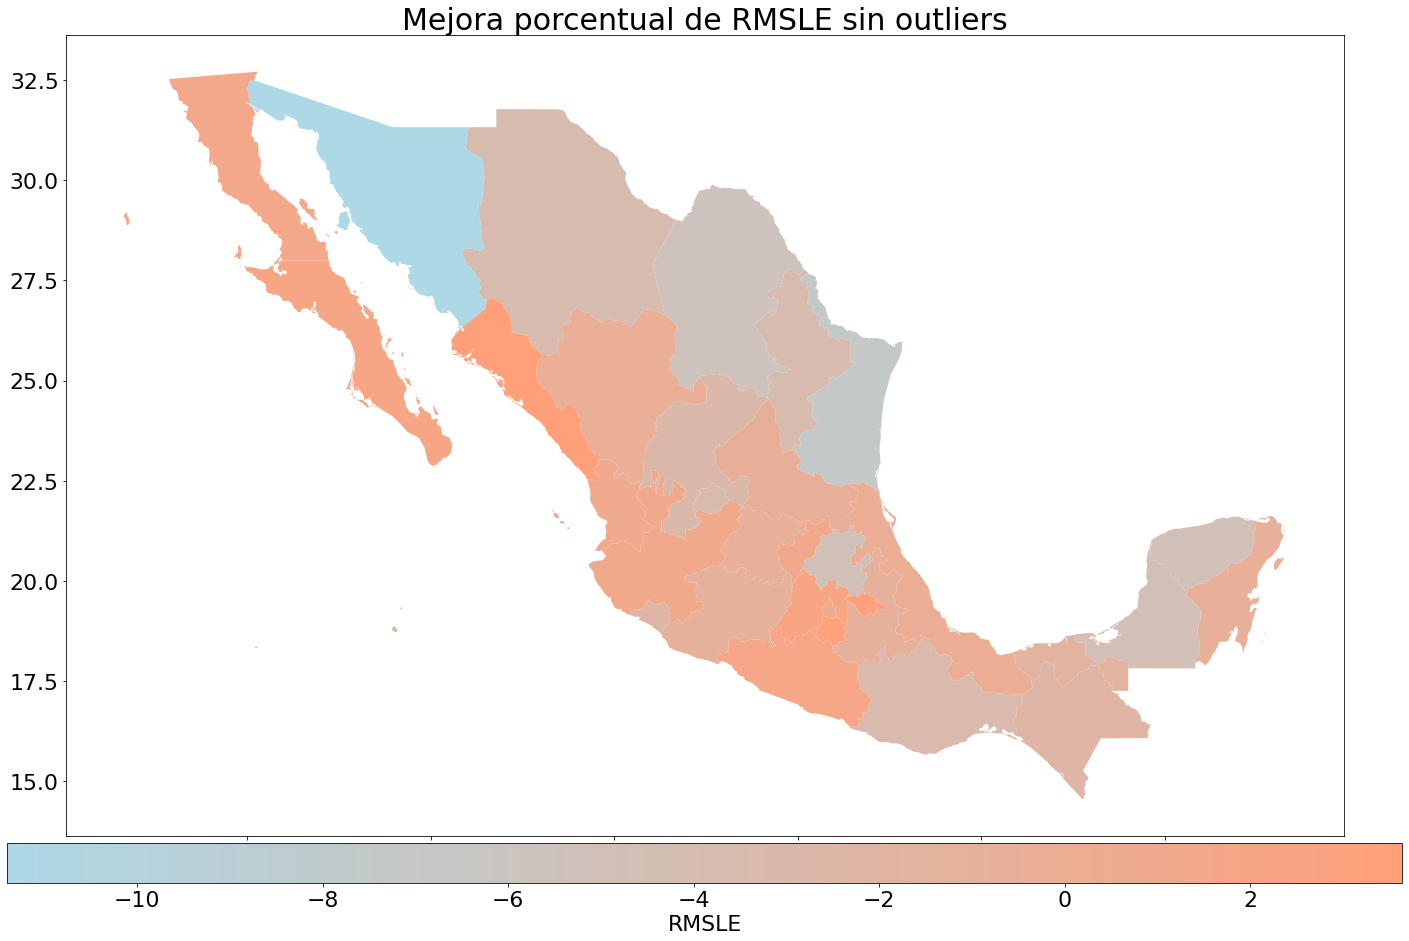

In [36]:
import geopandas as gpd
import pandas as pd
import numpy as np
import time
import math
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.metrics import *
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

!pwd
!python --version
import metnum

def mejora(row_con_percentiles):
    return ((100*row_con_percentiles['rmsle'])/row_con_percentiles['rmsle_viej']) -100
    

merged = gpd.read_file('test_precio_y_con_percentiles_zarpados_1598587937/geopandas.shp')

merged_old = gpd.read_file('test_precio_y_provincia_1598410601/geopandas.shp')

merged_old.drop('geometry',axis=1).to_csv(r'test_precio_y_provincia_1598410601.csv')
merged.drop('geometry',axis=1).to_csv(r'test_precio_y_con_percentiles_zarpados_1598587937.csv')

merged['improvement'] = merged.apply(lambda row: mejora(row),axis=1)


# pd.set_option('display.max_rows', None)
# # print (merged_old['province'])
# print (merged['province'])
# # print (merged['rmsle'].mean())
print (merged['rmsle'])
print (merged['rmsle_viej'])
print (merged.info())
print (merged['improvemen'])
# print("---------")
# print (merged_old['rmsle'])

plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(1, 1)
ax.set_title("Mejora porcentual de RMSLE sin outliers", fontsize=30)
fig.set_size_inches(25, 16, forward=True)

divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.1)
cmap = LinearSegmentedColormap.from_list(
    'mycmap', [(0, 'lightblue'), (1, 'lightsalmon')])

merged.plot(column='improvemen', ax=ax, cax=cax, cmap=cmap, legend=True, legend_kwds={'label': "RMSLE",
                                                                                    'orientation':'horizontal'})